# Logistic Regression

> Import necessari

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

> Montaggio di Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Divisione del dataset in train e test

In [3]:
# Lettura del dataset (drive)
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/FakeAccountDetection/datasets/cleaned_dataset.csv'

In [24]:
# Lettura del dataset (local)
csv_path = '../datasets/cleaned_dataset.csv'

In [25]:
df = pd.read_csv(csv_path)

In [26]:
# Divisione in train e test set
X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

### 1.1 Addestramento senza iperparametri

In [27]:
# Istanziazione e addestramento del classificatore
lrc = LogisticRegression(random_state=42)
lrc.fit(X_train, y_train)
y_pred = lrc.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9357889497262319
Precision: 0.8997265268915223
Recall: 0.9811133200795229
F1-Score: 0.9386590584878745


## 2. Grid Search Cross Validation

In [28]:
# Griglia dei parametri
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet', None],        # tecnica di regolarizzazione utlizzata per ridurre l'overfitting
    'C': [1.0, 2.0, 5.0, 10.0, 20.0],                   # inverso della forza di regolarizzazione; valori più piccoli forniscono una penalità
                                                        # maggiore, valori grandi una penalità minore (simile a SVM)
    'fit_intercept': [True, False],                     # specifica se deve essere aggiunto un termine di bias al modello nella decision function
    'solver': ['liblinear', 'lbfgs', 'saga'],           # algoritmo di ottimizzazione
    'l1_ratio': [0.25, 0.5, 0.75],                      # influenza della regolarizzazione L1 in Elasticnet
    'max_iter': [100, 500, 1000]
}

In [29]:
# Istanziazione del classificatore (random_state controlla la casualità)
lrc = LogisticRegression(random_state=42)

In [30]:
%%time
warnings.filterwarnings('ignore') # disabilito eventuali warnings a causa delle incompatibilità dei solver nelle diverse combinazioni di parametri

# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=lrc, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

warnings.resetwarnings()    # riabilito i warnings

Best Parameters: {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
CPU times: total: 48.8 s
Wall time: 20min 42s


In [36]:
# Vediamo come si comporta nelle diverse combinaizoni di parametri
cvres = grid_search.cv_results_

for i, (f1, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: F1-Score {f1}, Parametri {params}")

Iterazione 0: F1-Score 0.9318331430082818, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Iterazione 1: F1-Score 0.9323630520266738, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Iterazione 2: F1-Score 0.9256482519317688, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Iterazione 3: F1-Score 0.9299121148272249, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Iterazione 4: F1-Score nan, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
Iterazione 5: F1-Score 0.9257643077086307, Parametri {'C': 1.0, 'fit_intercept': True, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Iterazione 6: F1-Score nan, Parametri {'C': 1.0, 'fit_interce

## 4. Metriche del modello migliore

> Vengono misurate le metriche a seguito dell'Hyperparameter Tuning.

In [32]:
lrc_final = grid_search.best_estimator_
y_pred = lrc_final.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9367844698855152
Precision: 0.9028414298808433
Recall: 0.9791252485089463
F1-Score: 0.9394372913686219


### 4.1 Learning Curve

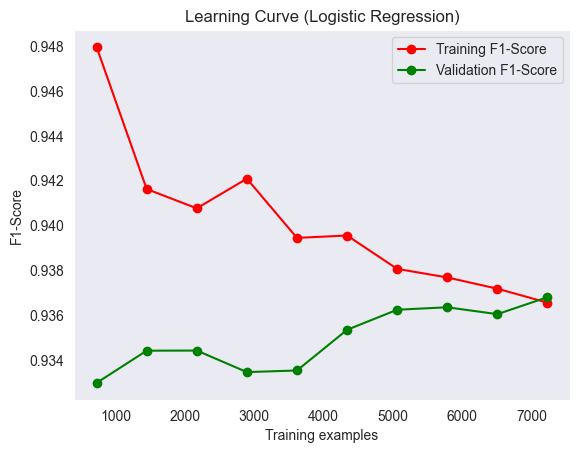

In [33]:
# Istanzia un nuovo modello Logistic Regression con i migliori parametri ottenuti in precedenza
lrc = LogisticRegression(random_state=42, **grid_search.best_params_)

# Calcolo la learning curve
train_sizes, train_scores, test_scores = learning_curve(lrc, X_train, y_train, scoring='f1',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, cv=10)

# Calcola la media dei punteggi ottenuti nelle diverse iterazioni di cross validation
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Traccio la curva di apprendimento
plt.figure()
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("F1-Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1-Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation F1-Score")

plt.legend(loc="best")
plt.show()

### 4.2 Matrice di confusione

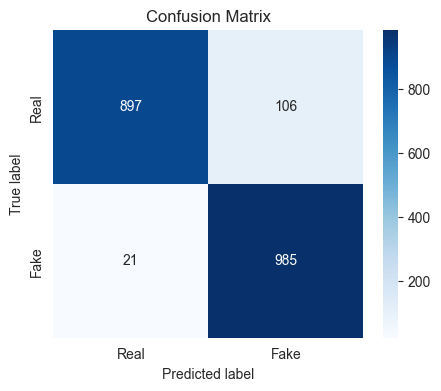

In [34]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### 4.3 Roc Curve

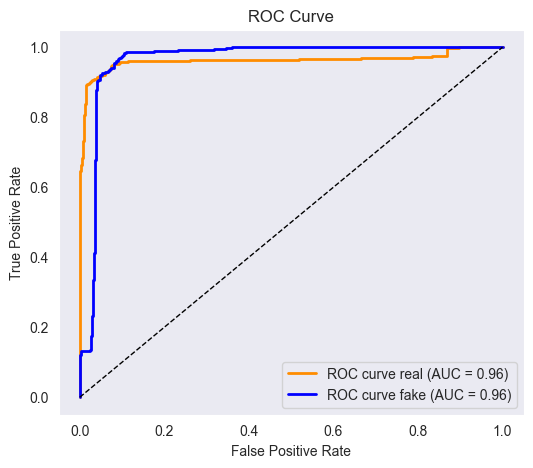

In [35]:
y_proba = lrc_final.predict_proba(X_test)

# Calcolo della curva ROC per la classe 'real' (label 0)
fpr_real, tpr_real, _ = roc_curve(y_test, y_proba[:, 0], pos_label=0)
roc_auc_real = auc(fpr_real, tpr_real)

# Calcolo della curva ROC per la classe 'fake' (label 1)
fpr_fake, tpr_fake, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# Tracciamento delle curve ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, color='darkorange', lw=2, label=f'ROC curve real (AUC = {roc_auc_real:.2f})')
plt.plot(fpr_fake, tpr_fake, color='blue', lw=2, label=f'ROC curve fake (AUC = {roc_auc_fake:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()